In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torchvision
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import tensorflow as tf

2023-04-25 19:57:58.707020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 19:57:59.463543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
torch.cuda.set_device(1)
print(torch.cuda.current_device())

True
2
1


In [3]:
df = pd.read_csv('EyePACS/trainLabels.csv')
len(df), df

(35108,
              image  level
 0          10_left      0
 1         10_right      0
 2          13_left      0
 3         13_right      0
 4          15_left      1
 ...            ...    ...
 35103  44347_right      0
 35104   44348_left      0
 35105  44348_right      0
 35106   44349_left      0
 35107  44349_right      1
 
 [35108 rows x 2 columns])

In [4]:
df['level'].value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [5]:
base_dir = 'EyePACS/eyepacs_preprocess/eyepacs_preprocess'
len(os.listdir(base_dir)), os.listdir(base_dir)[:10]

(35108,
 ['2359_left.jpeg',
  '30985_left.jpeg',
  '31178_right.jpeg',
  '38250_left.jpeg',
  '42768_left.jpeg',
  '13638_left.jpeg',
  '1299_left.jpeg',
  '18206_left.jpeg',
  '17086_right.jpeg',
  '25709_right.jpeg'])

In [6]:
def image_preprocessing(img):
    img = img.astype(np.uint8)
    #CLAHE on L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    new_img = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    
    return new_img

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.jpeg')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
eyePACS_train = CustomImageDataset(csv_file='EyePACS/train.csv',
                             img_dir='EyePACS/eyepacs_preprocess/eyepacs_preprocess',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.RandomHorizontalFlip(p=0.2),
                                                           transforms.RandomVerticalFlip(p=0.2),
                                                           transforms.ColorJitter(brightness=0.1,
                                                                                  contrast=0.1,
                                                                                  saturation=0.01,
                                                                                  hue=0.01),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.412,0.287,0.204],
                                                                               std=[0.497,0.350,0.263]),                                                           
                                                           transforms.Resize((512,512)),
                                                           
                                                          ])
                            )
eyePACS_val = CustomImageDataset(csv_file='EyePACS/val.csv',
                             img_dir='EyePACS/eyepacs_preprocess/eyepacs_preprocess',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.410,0.286,0.205],
                                                                               std=[0.495,0.349,0.263]),                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )
eyePACS_test = CustomImageDataset(csv_file='EyePACS/test.csv',
                             img_dir='EyePACS/eyepacs_preprocess/eyepacs_preprocess',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.411,0.285,0.202],
                                                                               std=[0.495,0.349,0.261]),
                                                           transforms.Resize((512,512))
                                                          ])
                            )

In [9]:
batch_size=128
train_dataloader = DataLoader(eyePACS_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(eyePACS_test, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(eyePACS_val, batch_size=batch_size, shuffle=True)

In [10]:
# Display image and label.
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# npimg = img.numpy()
# label = train_labels[0]
# plt.imshow(np.transpose(npimg,(1,2,0)))
# plt.show()
# print(f"Label: {label}")

# MODEL DEFINITION

In [11]:
nSamples = [16513, 1560, 3384, 558, 453]
norm_weights = [1 - (x /sum(nSamples)) for x in nSamples]
print(norm_weights)
model_weights = torch.tensor(norm_weights)
print(norm_weights)

[0.2650436175894606, 0.9305679188178743, 0.8493857931280042, 0.9751646786540858, 0.9798379918105751]
[0.2650436175894606, 0.9305679188178743, 0.8493857931280042, 0.9751646786540858, 0.9798379918105751]


In [12]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class TransferInceptionV3(nn.Module):
    def __init__(self, num_classes=5, dropout=0.5):
        super(TransferInceptionV3, self).__init__()
        self.features = models.inception_v3(pretrained=True)
        self.features.aux_logits = False 
        for param in self.features.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.features(x)
        #x = x.logits
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = TransferInceptionV3().to(device)
criterion = nn.CrossEntropyLoss(weight=model_weights.to(device))
model.to(torch.cuda.current_device())

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransferInceptionV3(
  (features): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import timeit

# Train the model
num_epochs = 70

min_val_loss = float('inf')
PATH = 'eyepacs_results/eyepacs_best.pt'

All_train_loss = []
All_val_loss = []

checkpoint=torch.load('eyepacs_results/w_32/w_32_eyepacs_last.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for epoch in range(num_epochs):
    start_time = timeit.default_timer()
    
    # Train the model on the training set
    total_train_loss = 0
    model.train()
    _batch = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        #take argmax of the logits before computing the loss?
        outputs = model(images)
        #logits = outputs.logits
        loss = criterion(outputs, labels)
        total_train_loss += loss * images.shape[0]
        _batch += 1
        if _batch % 50 == 0:
            with open('eyepacs_results/run_log.txt', 'a') as logfile:
                logfile.write(f"{_batch}: {loss}\n")
            print(f"{_batch}: {loss}")
        # Backward and optimize
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the validation set
    print(f"---| VALIDATING EPOCH #{epoch+1} |---")
    with open('eyepacs_results/run_log.txt', 'a') as logfile:
        logfile.write(f"---| VALIDATING EPOCH #{epoch+1} |---\n")
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct = 0
        total = 0
        _batch = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #logits = outputs.logits
            #take argmax of the logits before computing the loss 
            #outputs = outputs.softmax(dim=1)
            val_loss = criterion(outputs, labels)
            _batch += 1
            if _batch % 40 == 0:
                with open('eyepacs_results/run_log.txt', 'a') as logfile:
                    logfile.write(f"{_batch}: {val_loss}\n")
                print(f"{_batch}: {val_loss}")
            total_val_loss += val_loss.item() * images.shape[0]
            #take argmax of the logits before computing the loss 
            predicted = torch.argmax(outputs, 1) #did torch.argmax instead of torch.max
            total += labels.size(0)
            correct += (predicted == labels).sum()
    avg_train_loss = total_train_loss/22468
    avg_val_loss = total_val_loss/5617
    print()
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    with open('eyepacs_results/run_log.txt', 'a') as logfile:
        logfile.write(f"\nEpoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}\n")
    All_train_loss.append(avg_train_loss.cpu())
    All_val_loss.append(avg_val_loss)
    
    if avg_val_loss < min_val_loss:
        print("---| SAVING CHECKPOINT TO DISK |---")
        with open('eyepacs_results/run_log.txt', 'a') as logfile:
            logfile.write("---| SAVING CHECKPOINT TO DISK |---\n")
        min_val_loss = avg_val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)
        
    elapsed = timeit.default_timer() - start_time
    print("Epoch took", str(elapsed//60), "minutes")
    print("---------------------------------------------------------------")
    with open('eyepacs_results/run_log.txt', 'a') as logfile:
        logfile.write("Epoch took " + str(elapsed//60) + " minutes\n")
        logfile.write("---------------------------------------------------------------\n")

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


50: 0.18547582626342773
100: 0.1852884441614151
150: 0.16974671185016632
---| VALIDATING EPOCH #1 |---
40: 3.302175998687744

Epoch 1/70: Train Loss = 0.1492, Val Loss = 2.4526
---| SAVING CHECKPOINT TO DISK |---
Epoch took 50.0 minutes
---------------------------------------------------------------
50: 0.20767833292484283


In [ ]:
print(_batch, epoch)

In [15]:
NAll_train_loss = []
for x in All_train_loss:
    NAll_train_loss.append(x.detach().numpy() if isinstance(x, torch.Tensor) else x)

NAll_val_loss = np.array(All_val_loss)
np.savetxt("eyepacs_results/6_e_train_loss.txt", NAll_train_loss)
np.savetxt("eyepacs_results/6_e_val_loss.txt", NAll_val_loss)

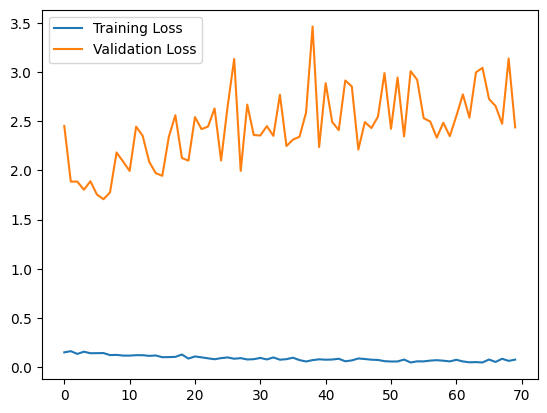

In [16]:
plt.plot(NAll_train_loss, label='Training Loss')
plt.plot(NAll_val_loss,label='Validation Loss')
plt.legend()
plt.show
plt.savefig('eyepacs_results/trainLossValLoss.png')

In [17]:
#Testing             
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu())
        y_pred.extend(predicted.cpu())

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
# Compute the accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')

print(f'kappa score: {kappa:4f}')

Test Accuracy: 0.8270
Test F1 Score: 0.8147
kappa score: 0.572183


In [19]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[4867  137  153    1    3]
 [ 290   98   99    1    0]
 [ 254   59  714   25    6]
 [   9    1  112   47    5]
 [  11    0   32   17   82]]
              precision    recall  f1-score   support

           0      0.896     0.943     0.919      5161
           1      0.332     0.201     0.250       488
           2      0.643     0.675     0.659      1058
           3      0.516     0.270     0.355       174
           4      0.854     0.577     0.689       142

    accuracy                          0.827      7023
   macro avg      0.648     0.533     0.574      7023
weighted avg      0.809     0.827     0.815      7023



In [20]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'eyepacs_results/eyepacs_last.pt')